# Introduction

This notebook backtests 500 stock tickers. After reading in the stock tickers from a CSV file, it calls `backtester()` to do all the hard work. This is basically a wrapper for the `backtester()`. The `backtester()` is stored in backtest.py.

In [1]:
from backtest import get_hist, smooth, features, stringify, print_ticker_heading, balanced_scorecard, \
                     determine_minima_n_maxima, align_minima_n_maxima, plot_trades, split_data, \
                     get_signals, merge_buy_n_sell_signals, extract_trades, get_possible_trades, \
                     backtester
import pandas as pd
import numpy as np

from   frankie     import DayForecast, optimize, baseline, cross_val_tpr
import yfinance as yf

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score, roc_auc_score
from sklearn.datasets import load_breast_cancer, load_iris, make_moons, make_circles, make_classification
from sklearn.linear_model import LogisticRegression
from category_encoders import WOEEncoder

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import MinMaxScaler, KBinsDiscretizer, FunctionTransformer
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer

from datetime import date, timedelta

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.signal import savgol_filter, argrelmin, argrelmax

import gc; gc.enable()

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
# suppress output of plotting all the trades as this is quite a lot...
# plot_trades(tickers, min_indices, max_indices)

In [4]:
DATAPATH = '/Users/frkornet/Flatiron/Stock-Market-Final-Project/data/'
sdf = pd.read_csv(f'{DATAPATH}stocks_500.csv')
idx = (sdf.TICKER > '')
sdf = sdf.loc[idx].reset_index()
tickers = sdf.TICKER.to_list()

In [5]:
print(len(tickers), tickers)

483 ['ARAY', 'AYI', 'ADUS', 'IOTS', 'ADRO', 'AAP', 'WMS', 'ARPO', 'AES', 'AGCO', 'AGRX', 'ALRN', 'AIRT', 'AKRX', 'ALK', 'AA', 'AXU', 'ALXN', 'AQN', 'ALGN', 'ALLK', 'ABTX', 'AMRK', 'AEP', 'AFG', 'AMNB', 'AMT', 'AMWD', 'AMP', 'AMGN', 'FOLD', 'AMPH', 'PLAN', 'ATRS', 'ACRE', 'AGX', 'ARMP', 'ARWR', 'AIZ', 'ALOT', 'AAME', 'ATO', 'ATRC', 'ACB', 'ADP', 'AVB', 'AGR', 'AVY', 'AVA', 'BW', 'BTN', 'TBBK', 'BAC', 'BOCH', 'BPRN', 'BRN', 'BSET', 'BTE', 'BCBP', 'BASI', 'BPTH', 'BB', 'BKH', 'BMCH', 'BA', 'BOOT', 'BPFH', 'BXP', 'EPAY', 'BDGE', 'BCOV', 'BFAM', 'BHF', 'BRT', 'BLDR', 'BFST', 'CAMP', 'CPB', 'CNQ', 'CBNK', 'CCBG', 'COF', 'CFFN', 'CDLX', 'CSL', 'KMX', 'CARO', 'CASS', 'CBZ', 'CBL', 'CBMB', 'CM', 'CNP', 'CHRA', 'CTHR', 'CRL', 'CCF', 'CHEF', 'CHE', 'CHMI', 'CVX', 'CMRX', 'CAAS', 'CCRC', 'CXDC', 'CYD', 'CHD', 'CHUY', 'CINF', 'CTRN', 'CFG', 'CHCO', 'CLFD', 'CMS', 'JVA', 'COLM', 'CMCO', 'CBSH', 'COMM', 'JCS', 'CBU', 'TCFC', 'CRK', 'CAG', 'TCS', 'CORT', 'CPLG', 'COST', 'ICBK', 'CVIA', 'BREW', 'CRAI',

In [6]:
%time myPnL_df, my_Capital_df, possible_trades_df = backtester("backtest_0500.log", tickers, "10y", 10000, 5)

Simulating 457 stocks



local minima and maxima: 100%|██████████| 457/457 [03:38<00:00,  2.09it/s]



Unable to determine local minima and maxima for the following tickers:
['WCN']
Simulating with remaining 456 stocks



possible trades: 100%|██████████| 456/456 [10:02<00:00,  1.32s/it]



Possible trades to simulate: 4681
Trading days to simulate   : 741



simulate trades: 100%|██████████| 741/741 [03:35<00:00,  3.44it/s]

CPU times: user 28min 43s, sys: 9.48 s, total: 28min 53s
Wall time: 17min 19s


# Summary Chart

This chart provides an overview of well the backtest went and how it increased or decreased the initial capital over time.

In [7]:
idx = myPnL_df.action=='BUY'
first_buy_date = myPnL_df.loc[idx].date.min()
first_buy_date

Timestamp('2017-03-22 00:00:00')

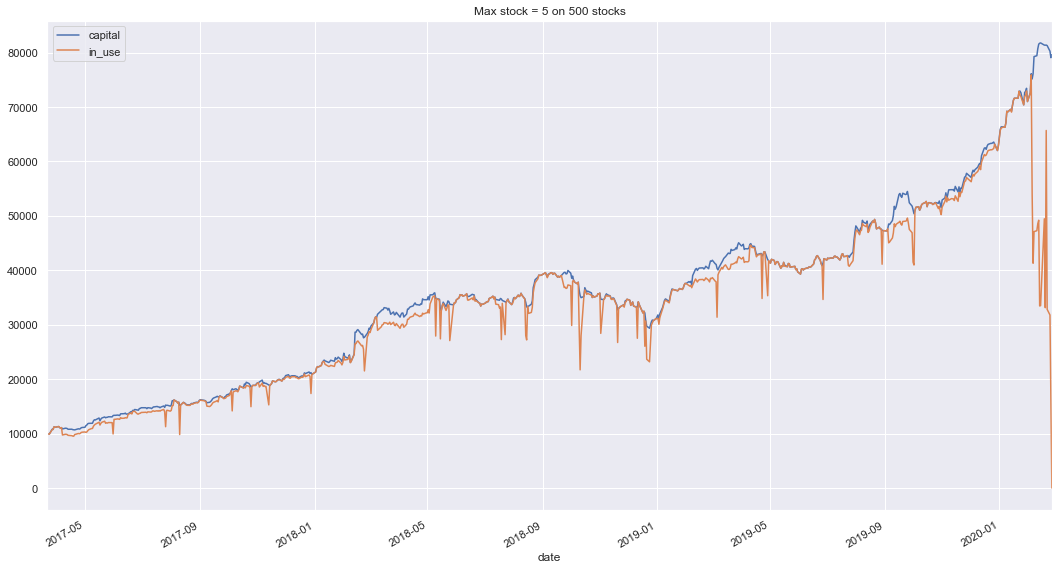

In [8]:
#myPnL_df, my_Capital_df = backtester()
myCapital_df = my_Capital_df
myCapital_df.index = myCapital_df.date
to_plot_cols = ['capital', 'in_use']
myCapital_df[to_plot_cols][first_buy_date:].plot(figsize=(18,10))
plt.title('Max stock = 5 on 500 stocks')
plt.show()

# Analysis of Results

The cells below perform a simple analysis. They look at the completed trades. For each trade it calculates the gain and gain percentage. With that it then displays the top ten losses and top ten gains. It ends with calculating the percentage of trades that resulted in a loss.

In [9]:
sell_df = myPnL_df[myPnL_df.action=='SELL'].copy()
sell_df['gain'] = (sell_df.close_amount - sell_df.orig_amount)
sell_df['gain_pct'] = round((sell_df.gain / sell_df.orig_amount)*100, 2)
sell_df['daily_comp_pct'] = (((1 + sell_df.gain_pct/100) ** (1/ sell_df.days_in_trade)) - 1)*100
sell_df

,action,close_amount,daily_gain,daily_pct,daily_return,date,days_in_trade,invested,no_shares,orig_amount,stop_loss,ticker,gain,gain_pct,daily_comp_pct
0,SELL,2000.000000,2.273737e-13,1.136868e-14,NaN,2017-03-22,1,0,93.808630,2000.000000,19.188,FCBC,2.273737e-13,0.00,0.000000
0,SELL,2000.000000,0.000000e+00,0.000000e+00,NaN,2017-03-22,1,0,123.685838,2000.000000,14.553,DLA,0.000000e+00,0.00,0.000000
0,SELL,2000.000000,0.000000e+00,0.000000e+00,NaN,2017-03-22,1,0,146.520147,2000.000000,12.285,MNTA,0.000000e+00,0.00,0.000000
0,SELL,2000.000000,2.273737e-13,1.136868e-14,NaN,2017-03-22,1,0,70.671378,2000.000000,25.470,TRMK,2.273737e-13,0.00,0.000000
0,SELL,2000.000000,0.000000e+00,0.000000e+00,NaN,2017-03-22,1,0,215.053763,2000.000000,8.370,NATR,0.000000e+00,0.00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,SELL,16322.056937,-3.340577e+01,-2.042484e-01,NaN,2020-02-19,2,0,668.115306,16355.462702,22.032,FFBC,-3.340577e+01,-0.20,-0.100050
0,SELL,16549.629426,1.314235e+02,8.004744e-01,NaN,2020-02-21,7,0,243.376903,16172.395225,59.805,FCAP,3.772342e+02,2.33,0.329580
0,SELL,16229.487131,-4.243796e+01,-2.608048e-01,NaN,2020-02-21,2,0,606.256523,16271.925087,24.156,HFWA,-4.243796e+01,-0.26,-0.130085
0,SELL,15447.259496,-2.711988e+02,-1.725352e+00,NaN,2020-02-25,4,0,553.466840,16271.925087,26.460,CCBG,-8.246656e+02,-5.07,-1.292337


In [10]:
sell_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 548 entries, 0 to 0
Data columns (total 15 columns):
action            548 non-null object
close_amount      548 non-null float64
daily_gain        548 non-null float64
daily_pct         548 non-null float64
daily_return      0 non-null float64
date              548 non-null datetime64[ns]
days_in_trade     548 non-null int64
invested          548 non-null int64
no_shares         548 non-null float64
orig_amount       548 non-null float64
stop_loss         548 non-null float64
ticker            548 non-null object
gain              548 non-null float64
gain_pct          548 non-null float64
daily_comp_pct    548 non-null float64
dtypes: datetime64[ns](1), float64(10), int64(2), object(2)
memory usage: 68.5+ KB


In [11]:
sell_df.describe()

,close_amount,daily_gain,daily_pct,daily_return,days_in_trade,invested,no_shares,orig_amount,stop_loss,gain,gain_pct,daily_comp_pct
count,548.000000,548.000000,548.000000,0.0,548.000000,548.0,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000
mean,6475.135101,7.648271,0.137493,NaN,7.602190,0.0,1012.370953,6348.109234,58.445377,127.025867,2.192573,0.091347
std,3171.445397,290.563224,4.940910,NaN,14.816321,0.0,3196.647127,3024.249742,205.106780,770.027161,11.425137,1.015690
min,1814.993013,-1301.375714,-20.183486,NaN,1.000000,0.0,3.142930,1814.993013,0.180000,-1774.603246,-25.640000,-4.499411
25%,3760.782908,-42.903408,-0.727266,NaN,1.000000,0.0,82.239976,3713.889834,7.659000,-20.797831,-0.482500,-0.130941
50%,6620.141047,0.000000,0.000000,NaN,2.000000,0.0,225.669502,6643.418630,22.729500,0.000000,0.000000,0.000000
75%,7859.831855,39.395017,0.705742,NaN,6.000000,0.0,703.701007,7782.315809,60.698250,108.922845,1.890000,0.356630
max,21761.522771,3553.089504,86.956522,NaN,159.000000,0.0,45467.525455,16355.462702,3367.530000,11178.500995,105.630000,8.508064


In [12]:
sell_df.sort_values(by='gain_pct', ascending=True)[0:10]

,action,close_amount,daily_gain,daily_pct,daily_return,date,days_in_trade,invested,no_shares,orig_amount,stop_loss,ticker,gain,gain_pct,daily_comp_pct
0,SELL,5146.349413,-1301.375714,-20.183486,NaN,2018-05-15,12,0,5915.344153,6920.952659,1.053,ENT,-1774.603246,-25.64,-2.438542
0,SELL,5868.646868,-607.076597,-9.374653,NaN,2018-11-20,5,0,71.928507,6952.609466,86.994,ROST,-1083.962597,-15.59,-3.332880
0,SELL,6643.418630,-974.368066,-12.790698,NaN,2019-04-29,4,0,8857.891506,7794.944526,0.792,NOVN,-1151.525896,-14.77,-3.916653
0,SELL,3350.882555,-205.505574,-5.778491,NaN,2017-11-13,6,0,570.848817,3898.897419,6.147,IMMR,-548.014864,-14.06,-2.493727
0,SELL,6098.441380,-386.435889,-5.959032,NaN,2018-08-14,6,0,1207.612154,7088.683346,5.283,ENPH,-990.241967,-13.97,-2.476715
0,SELL,5462.542072,-338.762299,-5.839416,NaN,2019-10-01,21,0,222.869934,6316.133918,25.506,ODT,-853.591846,-13.51,-0.688767
0,SELL,2069.122771,-86.213449,-4.000000,NaN,2017-05-31,17,0,1436.890813,2385.238750,1.494,ARWR,-316.115979,-13.25,-0.832631
0,SELL,2637.060428,-134.087818,-4.838710,NaN,2017-08-10,7,0,893.918789,3039.323883,3.060,ISNS,-402.263455,-13.24,-2.008477
0,SELL,9419.924225,-565.195453,-5.660377,NaN,2019-10-02,8,0,4709.962112,10832.912858,2.070,REKR,-1412.988634,-13.04,-1.731361
0,SELL,6043.224276,-260.483805,-4.132231,NaN,2018-08-15,19,0,1736.558700,6946.234801,3.600,ARAY,-903.010524,-13.00,-0.730279


In [13]:
sell_df.sort_values(by='gain_pct', ascending=False)[0:10]

,action,close_amount,daily_gain,daily_pct,daily_return,date,days_in_trade,invested,no_shares,orig_amount,stop_loss,ticker,gain,gain_pct,daily_comp_pct
0,SELL,21761.522771,5.895834,0.027100,NaN,2020-02-05,64,0,589.583386,10583.021775,16.155,ENPH,11178.500995,105.63,1.132787
0,SELL,9261.114836,191.444234,2.110818,NaN,2018-03-09,36,0,2393.052929,4642.522683,1.746,ENPH,4618.592154,99.48,1.936692
0,SELL,7639.142433,3553.089504,86.956522,NaN,2018-02-13,31,0,1776.544752,3837.336664,1.944,ZN,3801.805769,99.07,2.245770
0,SELL,3338.659829,31.459692,0.951249,NaN,2017-04-07,11,0,393.246152,1985.893067,4.545,SYX,1352.766762,68.12,4.836099
0,SELL,13030.243546,211.054350,1.646394,NaN,2019-09-05,128,0,157.503246,8216.944347,46.953,MEDP,4813.299199,58.58,0.360875
0,SELL,10650.208847,332.734490,3.224961,NaN,2018-09-24,37,0,135.257923,6983.366558,46.467,EXAS,3666.842289,52.51,1.147233
0,SELL,12597.502586,1849.832480,17.211474,NaN,2019-09-16,20,0,716.989333,8288.396693,10.404,KOD,4309.105893,51.99,2.115284
0,SELL,3221.585643,-35.439577,-1.088096,NaN,2017-06-26,47,0,21.349143,2141.746002,90.288,NVDA,1079.839641,50.42,0.872424
0,SELL,8235.873344,0.000000,0.000000,NaN,2019-02-04,27,0,1176.553335,5871.001141,4.491,ENPH,2364.872203,40.28,1.261484
0,SELL,9135.684966,-28.573368,-0.311791,NaN,2019-02-26,61,0,86.585963,6723.400034,69.885,NEWR,2412.284932,35.88,0.503891


In [14]:
sell_df[sell_df.gain_pct < 0].count()[0], sell_df[sell_df.gain_pct < 0].count()[0]/len(sell_df)

(157, 0.2864963503649635)

In [15]:
myPnL_df

,action,close_amount,daily_gain,daily_pct,daily_return,date,days_in_trade,invested,no_shares,orig_amount,stop_loss,ticker
0,BUY,2000.000000,0.000000,0.000000,NaN,2017-03-22,0,0,215.053763,2000.000000,8.370,NATR
0,BUY,2000.000000,0.000000,0.000000,NaN,2017-03-22,0,0,93.808630,2000.000000,19.188,FCBC
0,BUY,2000.000000,0.000000,0.000000,NaN,2017-03-22,0,0,11.325028,2000.000000,158.940,TDG
0,BUY,2000.000000,0.000000,0.000000,NaN,2017-03-22,0,0,146.520147,2000.000000,12.285,MNTA
0,BUY,2000.000000,0.000000,0.000000,NaN,2017-03-22,0,0,49.164208,2000.000000,36.612,ICFI
...,...,...,...,...,...,...,...,...,...,...,...,...
0,CLOSE,16064.565431,-586.974506,NaN,-3.525046,2020-02-24,11,0,1544.669753,15848.311665,9.234,FOLD
0,CLOSE,15718.458248,-448.308140,NaN,-2.773023,2020-02-24,3,0,553.466840,16271.925087,26.460,CCBG
0,SELL,15447.259496,-271.198751,-1.725352,NaN,2020-02-25,4,0,553.466840,16271.925087,26.460,CCBG
0,CLOSE,15153.210276,-911.355154,NaN,-5.673077,2020-02-25,12,0,1544.669753,15848.311665,9.234,FOLD


In [16]:
sell_df.ticker.unique(), len(sell_df.ticker.unique())

(array(['FCBC', 'DLA', 'MNTA', 'TRMK', 'NATR', 'SYNA', 'CCBG', 'ICFI',
        'CFR', 'TDG', 'AMP', 'AMGN', 'GCO', 'BTE', 'CVI', 'EXAS', 'HOFT',
        'ARWR', 'IMMR', 'JCS', 'SYX', 'ISSC', 'CMS', 'MBI', 'ROST', 'ARAY',
        'ZN', 'WOR', 'GFN', 'CORT', 'ISNS', 'BASI', 'FOLD', 'MSEX', 'VSH',
        'TNAV', 'RNST', 'PEG', 'CREE', 'NWFL', 'KRA', 'ADUS', 'MTSC',
        'STRL', 'DPZ', 'FICO', 'WMT', 'GMO', 'SIGI', 'FLNT', 'COST',
        'LAWS', 'NSYS', 'NVDA', 'ETR', 'ITT', 'POWL', 'RF', 'DSGX', 'HWC',
        'JBSS', 'NAV', 'AMWD', 'CRAI', 'AEP', 'NSIT', 'WEC', 'CRK', 'KRC',
        'CTHR', 'BREW', 'AMT', 'ATRS', 'VIAV', 'CRL', 'TRNS', 'NOA',
        'IMAX', 'WAT', 'ALOT', 'EDSA', 'CTRN', 'PCTI', 'ENT', 'YUM',
        'IDXX', 'KIRK', 'RGEN', 'PRTS', 'WINA', 'DRI', 'USIO', 'TR',
        'FISV', 'TRIP', 'MDP', 'KMX', 'AXU', 'SLG', 'WMS', 'IAG', 'COF',
        'BAC', 'MKL', 'ADP', 'EBF', 'ENV', 'AVY', 'ROK', 'CHEF', 'S',
        'HTBI', 'AGCO', 'AES', 'CHCO', 'CUBE', 'TWIN', 'CASS', 'S

In [17]:
sell_df[['ticker', 'gain']].groupby(by='ticker').sum().reset_index().sort_values(by='gain', ascending=False)[0:10]

,ticker,gain
71,ENPH,17171.723385
76,EXAS,7320.020537
141,NOA,5217.137621
132,MEDP,4813.299199
124,KOD,4544.466797
191,SYX,3454.391139
196,TNAV,3193.553639
150,NXRT,3013.592895
147,NVDA,2714.996530
140,NEWR,2412.284932


In [18]:
sell_df[['ticker', 'gain']].groupby(by='ticker').sum().reset_index().sort_values(by='gain', ascending=True)[0:10]

,ticker,gain
167,REKR,-1412.988634
22,ATRS,-1382.977561
142,NOVN,-1151.525896
10,AGRX,-1143.357910
190,SYNC,-1047.377488
151,ODT,-853.591846
160,PRPL,-853.214982
41,CCBG,-824.665591
188,SYF,-811.657194
156,PCTY,-798.457948


In [19]:
sell_df[['ticker', 'gain']].groupby(by='ticker').mean().reset_index().sort_values(by='gain', ascending=False)[0:10]

,ticker,gain
132,MEDP,4813.299199
71,ENPH,4292.930846
150,NXRT,3013.592895
140,NEWR,2412.284932
97,GWRS,1959.547846
34,BPRN,1617.718787
196,TNAV,1596.776820
124,KOD,1514.822266
192,TAC,1376.832240
213,WING,1235.165999


In [20]:
sell_df[['ticker', 'gain']].groupby(by='ticker').mean().reset_index().sort_values(by='gain', ascending=True)[0:10]

,ticker,gain
167,REKR,-1412.988634
142,NOVN,-1151.525896
151,ODT,-853.591846
156,PCTY,-798.457948
129,LUNA,-791.335648
10,AGRX,-571.678955
41,CCBG,-412.332796
190,SYNC,-349.125829
160,PRPL,-284.404994
188,SYF,-270.552398


In [21]:
myCapital_df.tail()

,date,capital,in_use,free
date,,,,
2020-02-20,2020-02-20,81380.8,65690.8,15690
2020-02-21,2020-02-21,81287.4,32818.3,48469.1
2020-02-24,2020-02-24,80252.1,31783,48469.1
2020-02-25,2020-02-25,79069.5,15153.2,63916.3
2020-02-26,2020-02-26,79610.2,0,79610.2


In [22]:
len(possible_trades_df)

4681

In [23]:
possible_trades_df.to_csv(f'{DATAPATH}possible_trades_0500.csv', index=False)
myCapital_df.to_csv(f'{DATAPATH}capital_0500.csv', index=False)
myPnL_df.to_csv(f'{DATAPATH}PnL_0500.csv', index=False)

In [24]:
ls ../data

F13_Renaissance_tech.csv  capital_0500.csv          possible_trades_1000.csv
F13_Renaissance_tech.txt  capital_1000.csv          possible_trades_1500.csv
PnL_0100.csv              capital_1500.csv          possible_trades_2000.csv
PnL_0500.csv              capital_2000.csv          stocks.csv
PnL_1000.csv              exclude.csv               stocks_100.csv
PnL_1500.csv              optimal_params.csv        stocks_1000.csv
PnL_2000.csv              possible_trades_0100.csv  stocks_2000.csv
capital_0100.csv          possible_trades_0500.csv  stocks_500.csv
